# Lbl2Vec

The main goal of this notebook is to classify each document into defined topics/classes using the algorithm Lbl2Vec (https://towardsdatascience.com/unsupervised-text-classification-with-lbl2vec-6c5e040354de).

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from lbl2vec import Lbl2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

import spacy

# -- Data

## Documents

In [2]:
bbc_news_df = pd.read_csv('../../datasets/BBC_News/dataset.csv')
bbc_news_df.head()

,document,class_name,class_index,dataset_type
0,hit shelf combine medium player phone gaming g...,tech,0,train
1,bid hope join host apply host tournament aim r...,sport,4,train
2,lord wrong detainee straw straw attack decisio...,politics,1,train
3,leak answer minister explain budget detail pri...,politics,1,train
4,delight manager pay tribute goal striker beat ...,sport,4,train


In [3]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

In [4]:
bbc_news_df['tagged_docs'] = bbc_news_df.apply(
    lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)])
    , axis=1)
bbc_news_df['doc_key'] = bbc_news_df.index.astype(str)
bbc_news_df.head()

,document,class_name,class_index,dataset_type,tagged_docs,doc_key
0,hit shelf combine medium player phone gaming g...,tech,0,train,"([hit, shelf, combine, medium, player, phone, ...",0
1,bid hope join host apply host tournament aim r...,sport,4,train,"([bid, hope, join, host, apply, host, tourname...",1
2,lord wrong detainee straw straw attack decisio...,politics,1,train,"([lord, wrong, detainee, straw, straw, attack,...",2
3,leak answer minister explain budget detail pri...,politics,1,train,"([leak, answer, minister, explain, budget, det...",3
4,delight manager pay tribute goal striker beat ...,sport,4,train,"([delight, manager, pay, tribute, goal, strike...",4


## Classes

In [5]:
def get_predefined_keywords(df, k):
    keywords = {}
    classes = df['class_name'].unique()

    for c in classes:
        documents_for_class = df[df['class_name'] == c]

        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(documents_for_class['document'])

        top_k_words = pd.DataFrame(
            data=X.toarray(), columns=vectorizer.get_feature_names_out()
        ).sum().sort_values(ascending=False).head(k).index.tolist()

        keywords[c] = top_k_words
    
    return keywords

In [6]:
N_KEYWORDS = 10
PREDEFINED_KEYWORDS = get_predefined_keywords(bbc_news_df, N_KEYWORDS)

In [7]:
class_df = pd.DataFrame()
class_df['class_index'] = bbc_news_df['class_index'].unique()
class_df['class_name'] = class_df['class_index'].apply(
    lambda class_index: bbc_news_df[bbc_news_df['class_index'] == class_index]['class_name'].unique()[0]
)
class_df['keywords'] = class_df['class_name'].apply(
    lambda class_name: PREDEFINED_KEYWORDS[class_name]
)
class_df['number_of_keywords'] = class_df['keywords'].apply(lambda keywords: len(keywords))
class_df.head()

,class_index,class_name,keywords,number_of_keywords
0,0,tech,"[game, phone, mobile, service, technology, use...",10
1,4,sport,"[win, play, game, player, good, match, team, f...",10
2,1,politics,"[election, party, labour, government, tory, pl...",10
3,3,business,"[company, firm, sale, rise, share, market, gro...",10
4,2,entertainment,"[film, good, award, show, win, music, star, in...",10


# -- Model

In [8]:
lbl2vec_model = Lbl2Vec(
    keywords_list=list(class_df['keywords']), 
    tagged_documents=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'train'], 
    label_names=list(class_df['class_name']),
)
lbl2vec_model.fit()

2023-09-27 11:23:44,079 - Lbl2Vec - INFO - Train document and word embeddings
2023-09-27 11:23:46,354 - Lbl2Vec - INFO - Train label embeddings


# -- Evaluation

In [9]:
train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'test'])

2023-09-27 11:23:46,384 - Lbl2Vec - INFO - Get document embeddings from model
2023-09-27 11:23:46,388 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-09-27 11:23:48,788 - Lbl2Vec - INFO - Calculate document embeddings
2023-09-27 11:23:49,055 - Lbl2Vec - INFO - Calculate document<->label similarities


In [10]:
evaluation_train = train_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
evaluation_test = test_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

y_true_train = evaluation_train['class_name']
y_pred_train = evaluation_train['most_similar_label']

y_true_test = evaluation_test['class_name']
y_pred_test = evaluation_test['most_similar_label']

print(f'F1 score on train set: {f1_score(y_true_train, y_pred_train, average="micro")}')
print(f'F1 score on test set: {f1_score(y_true_test, y_pred_test, average="micro")}')

F1 score on train set: 0.8651685393258428
F1 score on test set: 0.9056179775280899


The model seems to be random and the results change one iteration after another.

Text(0.5, 0.98, 'F1 score by class')

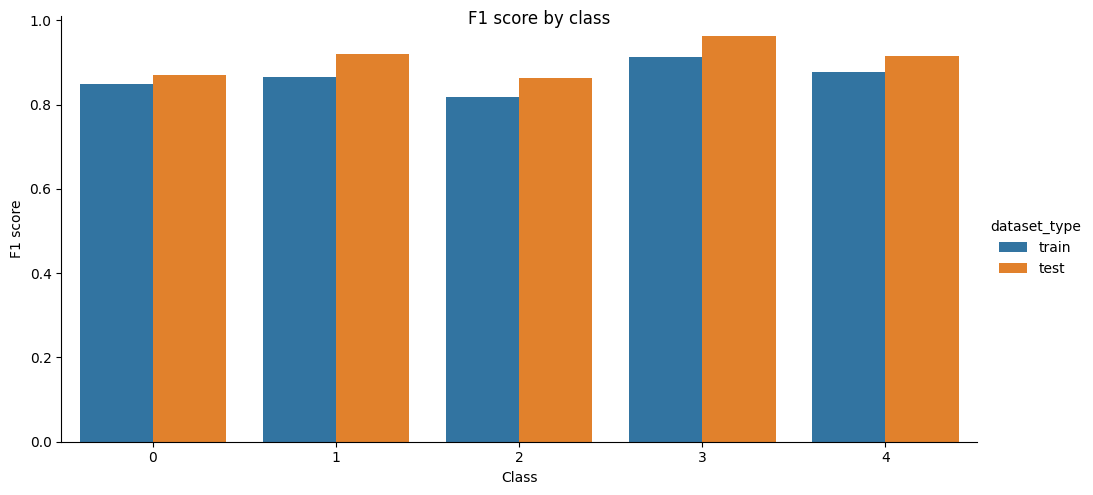

In [11]:
f1_scores_train = f1_score(y_true_train, y_pred_train, average=None)
f1_scores_test = f1_score(y_true_test, y_pred_test, average=None)

f1_scores_df = pd.DataFrame({'train': f1_scores_train, 'test': f1_scores_test})
f1_scores_df['class'] = f1_scores_df.index
f1_scores_df = f1_scores_df.melt(id_vars=['class'], var_name='dataset_type', value_name='f1_score')

fig = sns.catplot(data=f1_scores_df, x='class', y='f1_score', hue='dataset_type', kind='bar', height=5, aspect=2)
fig.set(xlabel='Class', ylabel='F1 score')
fig.fig.suptitle('F1 score by class')

- We can see that the model perform really well, and the more we add keywords the higher the F1 scores are + train and test are closer.
- There seems to be a limitation on the performance of the model, as the number of keywords becomes higher, the F1 scores decreases.

> **Problem:**
>
> Here we know the keywords for each classes. How to extract keywords in an unsupervised way without knowing the classes ?

# -- Keywords analysis

In [58]:
def train_and_eval(keywords: dict, n_iterations: int = 1):
    """ Train and evaluate the model with the given keyword and number of iterations. 
        The number of iteration can be used to reduce the randomness of the model.
    """
    # Create a dataframe with the most similar label for each document
    class_df = pd.DataFrame()
    class_df['class_index'] = bbc_news_df['class_index'].unique()
    class_df['class_name'] = class_df['class_index'].apply(
        lambda class_index: bbc_news_df[bbc_news_df['class_index'] == class_index]['class_name'].unique()[0]
    )
    class_df['keywords'] = class_df['class_name'].apply(
        lambda class_name: keywords[class_name]
    )
    class_df['number_of_keywords'] = class_df['keywords'].apply(lambda keywords: len(keywords))
    class_df.head()

    f1_train_scores = []
    f1_test_scores = []

    for iter in range(n_iterations):
        lbl2vec_model = Lbl2Vec(
            keywords_list=list(class_df['keywords']), 
            tagged_documents=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'train'], 
            label_names=list(class_df['class_name']),
            min_count=2,
            verbose=False
        )
        lbl2vec_model.fit()

        # Evaluate the model
        train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
        test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'test'])

        evaluation_train = train_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
        evaluation_test = test_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

        y_true_train = evaluation_train['class_name']
        y_pred_train = evaluation_train['most_similar_label']

        y_true_test = evaluation_test['class_name']
        y_pred_test = evaluation_test['most_similar_label']

        f1_scores_train = f1_score(y_true_train, y_pred_train, average=None)
        f1_scores_test = f1_score(y_true_test, y_pred_test, average=None)

        f1_train_scores.append(f1_scores_train)
        f1_test_scores.append(f1_scores_test)

        print(f'Iteration {iter+1}/{n_iterations} - F1 score on train set: {f1_score(y_true_train, y_pred_train, average="micro")} - F1 score on test set: {f1_score(y_true_test, y_pred_test, average="micro")}')

    f1_train_scores = np.array(f1_train_scores).mean(axis=0)
    f1_test_scores = np.array(f1_test_scores).mean(axis=0)

    f1_scores_df = pd.DataFrame({'train': f1_train_scores, 'test': f1_test_scores})
    f1_scores_df['class'] = f1_scores_df.index
    return f1_scores_df
    

In [68]:
def plot_f1_score(score_df: pd.DataFrame):
    f1_scores_df = score_df.melt(id_vars=['class'], var_name='dataset_type', value_name='f1_score')

    avg_f1_train = f1_scores_df[f1_scores_df['dataset_type'] == 'train']['f1_score'].mean()
    avg_f1_test = f1_scores_df[f1_scores_df['dataset_type'] == 'test']['f1_score'].mean()

    fig = sns.catplot(data=f1_scores_df, x='class', y='f1_score', hue='dataset_type', kind='bar', height=5, aspect=2)
    fig.set(xlabel='Class', ylabel='F1 score')
    fig.fig.suptitle(f'F1 score by class (train: {round(avg_f1_train, 6)}, test: {round(avg_f1_test, 6)})')
    fig.tight_layout()

Iteration 1/5 - F1 score on train set: 0.9241573033707865 - F1 score on test set: 0.9258426966292135
Iteration 2/5 - F1 score on train set: 0.8960674157303371 - F1 score on test set: 0.9011235955056179
Iteration 3/5 - F1 score on train set: 0.9028089887640449 - F1 score on test set: 0.903370786516854
Iteration 4/5 - F1 score on train set: 0.9191011235955057 - F1 score on test set: 0.9191011235955057
Iteration 5/5 - F1 score on train set: 0.9056179775280899 - F1 score on test set: 0.9078651685393259


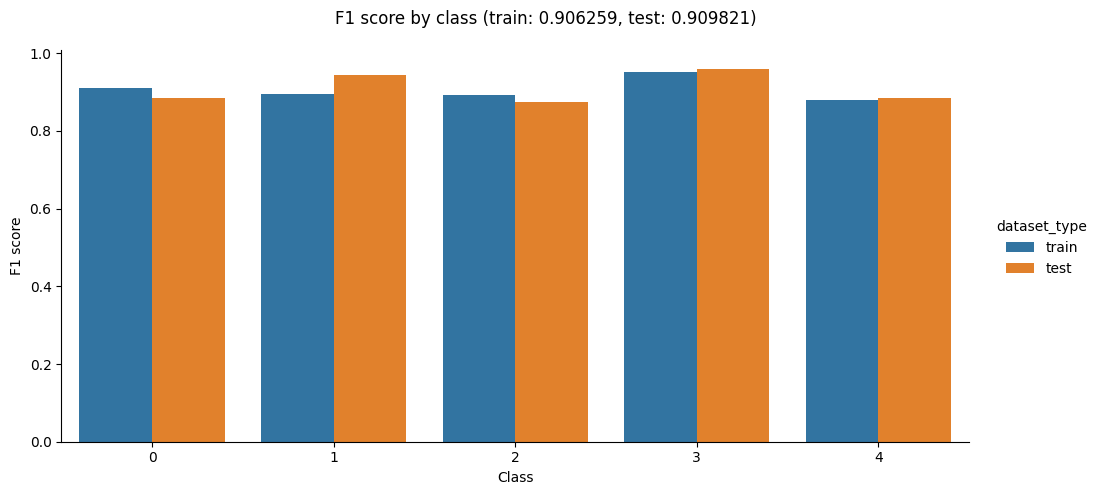

In [69]:
score_df = train_and_eval(PREDEFINED_KEYWORDS, n_iterations=5)
plot_f1_score(score_df)

The supposition that the model is random does not seems to be problematic on the predefined keywords.

In [70]:
classes_name = list(bbc_news_df['class_name'].unique())

In [71]:
def get_all_similar_keywords_by_class(classes_name):
    spacy_similarity_model = spacy.load('en_core_web_lg')
    resulting_keywords = {}

    all_documents_words = []
    for doc in bbc_news_df['document']:
        all_documents_words.extend(doc.split(' '))
    all_documents_words = list(set(all_documents_words))

    for class_name in classes_name:
        print(f'[INFO] Processing class: {class_name}...')

        similarity_levels = []
        
        for word in all_documents_words:
            spacy_word_1 = spacy_similarity_model(word)
            spacy_word_2 = spacy_similarity_model(class_name)

            if(not (spacy_word_1 and spacy_word_1.vector_norm and spacy_word_2 and spacy_word_2.vector_norm)):
                continue
            similarity_level = spacy_word_1.similarity(spacy_word_2)

            similarity_levels.append((word, similarity_level))

        similarity_levels = sorted(similarity_levels, key=lambda x: x[1], reverse=True)
        resulting_keywords[class_name] = [word for word, _ in similarity_levels]
        
    return resulting_keywords

ALL_SIMILAR_KEYWORDS_BY_CLASS = get_all_similar_keywords_by_class(classes_name)

In [72]:
def get_k_most_similar_keyword(k):
    resulting_keywords = {}
    for class_name, keywords in ALL_SIMILAR_KEYWORDS_BY_CLASS.items():
        resulting_keywords[class_name] = keywords[:k]
    return resulting_keywords

In [74]:
most_similar_keywords = get_k_most_similar_keyword(2)
most_similar_keywords

{'tech': ['tech', 'technology'],
 'sport': ['sport', 'tennis'],
 'politics': ['political', 'democracy'],
 'business': ['business', 'corporate'],
 'entertainment': ['entertainment', 'television']}

Iteration 1/10 - F1 score on train set: 0.8337078651685393 - F1 score on test set: 0.8337078651685393
Iteration 2/10 - F1 score on train set: 0.8140449438202247 - F1 score on test set: 0.8179775280898877
Iteration 3/10 - F1 score on train set: 0.8758426966292135 - F1 score on test set: 0.898876404494382
Iteration 4/10 - F1 score on train set: 0.8337078651685393 - F1 score on test set: 0.8134831460674158
Iteration 5/10 - F1 score on train set: 0.7393258426966293 - F1 score on test set: 0.7325842696629213
Iteration 6/10 - F1 score on train set: 0.8966292134831461 - F1 score on test set: 0.898876404494382
Iteration 7/10 - F1 score on train set: 0.8786516853932584 - F1 score on test set: 0.8943820224719101
Iteration 8/10 - F1 score on train set: 0.849438202247191 - F1 score on test set: 0.8449438202247193
Iteration 9/10 - F1 score on train set: 0.8393258426966292 - F1 score on test set: 0.8202247191011236
Iteration 10/10 - F1 score on train set: 0.8926966292134831 - F1 score on test set: 0

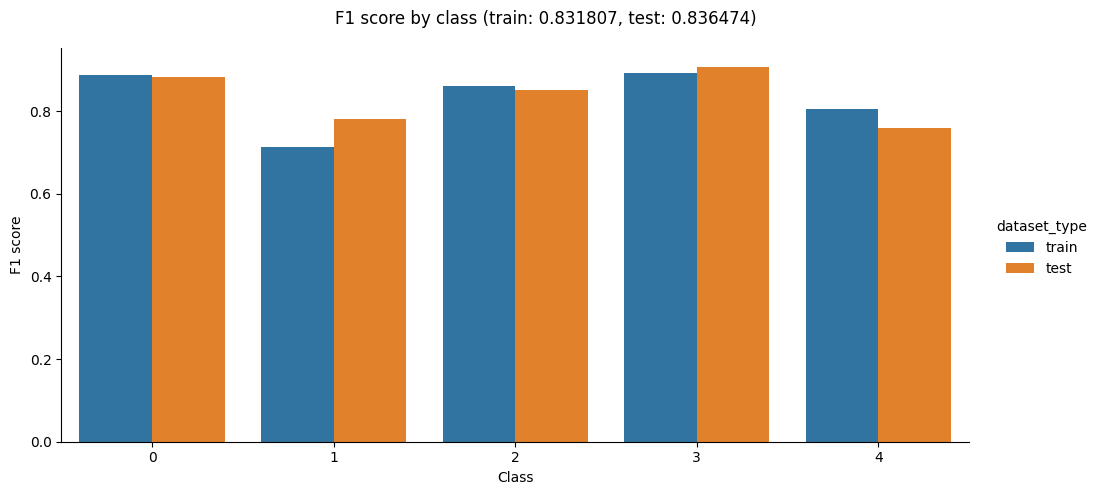

In [77]:
score_df = train_and_eval(most_similar_keywords, n_iterations=10)
plot_f1_score(score_df)

> **Question:**
>
> Why the model is now random ?

Iteration 1/20 - F1 score on train set: 0.8674157303370787 - F1 score on test set: 0.8471910112359551
Iteration 2/20 - F1 score on train set: 0.7724719101123596 - F1 score on test set: 0.7168539325842697
Iteration 3/20 - F1 score on train set: 0.8252808988764045 - F1 score on test set: 0.8179775280898877
Iteration 4/20 - F1 score on train set: 0.8775280898876404 - F1 score on test set: 0.8831460674157303
Iteration 5/20 - F1 score on train set: 0.7825842696629214 - F1 score on test set: 0.8247191011235955
Iteration 6/20 - F1 score on train set: 0.8550561797752809 - F1 score on test set: 0.8853932584269663
Iteration 7/20 - F1 score on train set: 0.8584269662921349 - F1 score on test set: 0.8539325842696629
Iteration 8/20 - F1 score on train set: 0.8134831460674158 - F1 score on test set: 0.8112359550561797
Iteration 9/20 - F1 score on train set: 0.7707865168539326 - F1 score on test set: 0.7370786516853932
Iteration 10/20 - F1 score on train set: 0.8808988764044944 - F1 score on test set

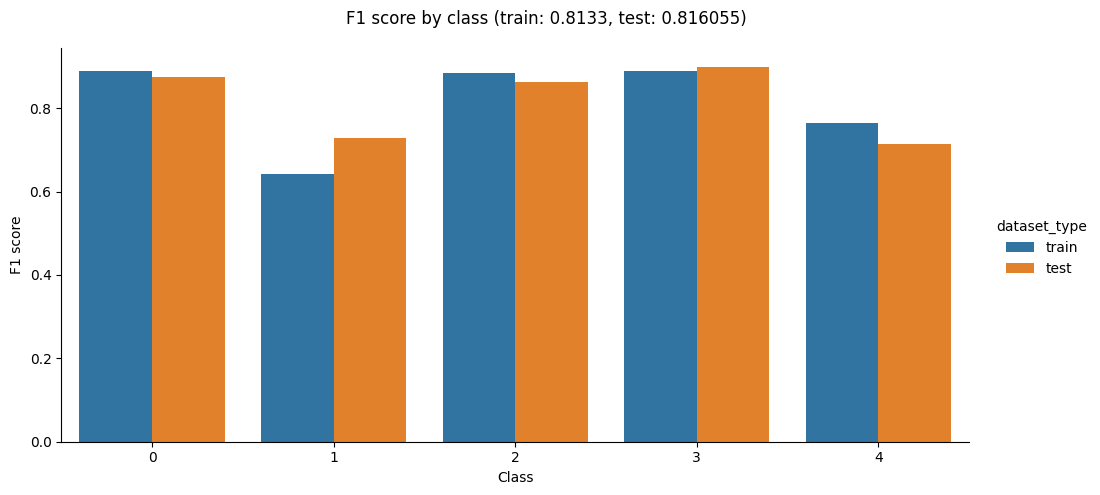

In [79]:
score_df = train_and_eval(get_k_most_similar_keyword(10), n_iterations=20)
plot_f1_score(score_df)